# Customer clustering algorithm for Membership Organization

#### author Ederson Madruga - april 2022

Sources:
https://www.letsdata.ai/
https://levelup.gitconnected.com/clustering-gps-co-ordinates-forming-regions-4f50caa7e4a1
https://stackoverflow.com/questions/28862334/k-means-with-selected-initial-centers

Libraries:
#!pip install Cython 
#!pip install pyproject-toml
#!pip install size-constrained-clustering
#!pip install k-means-constrained

About this project
This project aims to separate consumers into groups to hold periodic meetings.
We can previously define the centers of the clusters (centroids) or the algorithm will make the choice.
We can define the minimum and maximum number of individuals in the clusters.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from k_means_constrained import KMeansConstrained

## Parameters

In [2]:
#Fixed number of clusters - How many clusters should be created?
#Número de clusters fixos - Quantos clusters deverão ser criados?
cluster_number = 20

#File with point coordinates
#Arquivo com coordenadas dos pontos
points_file = 'ucs_coordenadas.xlsx'

# Maximum iterations 
#Número máximo de iterações do algorítmo
max_iter_number = 300


#=============================================================================================================================
#Calculation with minimum and maximum number of individuals in clusters
#Cálculo com número mínimo e máximo de indivíduos nos clusters
#--------------------------------------------------------------
#If kmeans_constrained == True then the algorithm will use the minimum and maximum numbers of individuals
# insert the min_number_individual variable (Minimum number of individuals in a Cluster)
#Se kmeans_constrained == True então o algorítmo irá deixar os clusters com os números mínimos e máximos de indivíduos
#Preencher a variável min_number_individual (Número mínimo de indivíduos em um Cluster)
kmeans_constrained = True

#Minimum number of individuals in a Cluster
#Número mínimo de indivíduos em um Cluster
min_number_individual = 1000

# Maximum number of individuals in a Cluster
#Número máximo de indivíduos em um Cluster
max_number_individual = 1800 ##If this parameter is at -1, the limit will be the total number of individuals 
                            #Se este parâmetro estiver em -1, o limite será o total de indivíduos
#--------------------------------------------------------------
#=============================================================================================================================
#--------------------------------------------------------------
#Centróides aleatórios (random_centroids = True) ou fixos (random_centroids = False). 
#Se fixos, determinar array "centroids_coords"
#Centróides aleatórios (random_centroids = True) ou fixos (random_centroids = False). 
#Se fixos, determinar array "centroids_coords"
random_centroids = True

#Array with centroid coordinates, case "(random_centroids = False"
#Array com coordenadas dos centróides, caso "(random_centroids = False"
centroids_coords = np.array([[367954.556,  6704527.217],[415420.062,6696398.761]], np.float64) #Exemple
#--------------------------------------------------------------

## Importing data file

In [3]:
df = pd.read_excel(points_file, index_col='UC')
df = df.loc[df['LIGADO'] == 'S']
df = df.loc[df['COORDENADAX'].isna() == False]
df.rename(columns={'COORDENADAX':'X', 'COORDENADAY':'Y'}, inplace = True)
df_full = df
df_full = df_full.reset_index()
df = df.drop(['LOCAL', 'POSTE', 'SE', 'AL', 'LIGADO', 'CLASSE'], axis=1)
df = df.reset_index()

In [4]:
df.head()

,UC,X,Y
0,4,427474.595,6714270.209
1,11,426273.037,6713425.845
2,13,431613.045,6715311.228
3,14,432818.329,6714907.775
4,15,430488.909,6716056.241


## Chart using the SSE metric
### Definition of the ideal number of Clusters

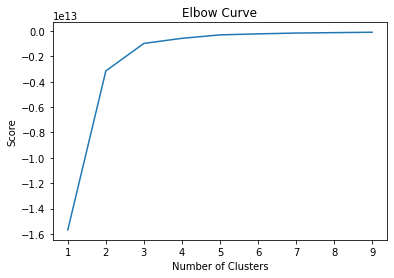

In [5]:
from sklearn.cluster import KMeans
K_clusters = range(1,10)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]
Y_axis = df[['Y']]
X_axis = df[['X']]
score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]
# Visualize
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

### K-means

In [6]:
if random_centroids == True:
    centroids = 'k-means++' 
else:
    centroids = centroids_coords;

if max_number_individual == -1:
    max_number_individual = df[df.columns[1:3]].count().X;    

In [7]:
if kmeans_constrained == True:
    clf = KMeansConstrained(
    n_clusters=cluster_number,
    size_min=min_number_individual,
    size_max= max_number_individual,
    init = centroids,
    max_iter = max_iter_number,
    random_state=0)
    
    clf.fit(df[df.columns[1:3]]) 
    df['cluster_label'] = clf.fit_predict(df[df.columns[1:3]])
    centers = clf.cluster_centers_
    labels = clf.labels_
    iteracoes = clf.n_iter_ #number of iterations(

else:
    kmeans = KMeans(n_clusters = cluster_number, init = centroids, max_iter = max_iter_number)
    kmeans.fit(df[df.columns[1:3]]) # Compute k-means clustering.
    df['cluster_label'] = kmeans.fit_predict(df[df.columns[1:3]])
    centers = kmeans.cluster_centers_ # Coordinates of cluster centers.
    labels = kmeans.predict(df[df.columns[1:3]]) # Labels of each point
    iteracoes = kmeans.n_iter_ #number of iterations

In [8]:
if random_centroids == True:
    print(f'Centróides em modo aleatório.') 
else:
    print(f'Os Centróides foram pré-definidos.') 
    
    
if kmeans_constrained == True:
    print(f'Número mínimo de indivíduos definidos em {min_number_individual}.') 
else:
    print(f'Não há restrições quanto ao número de indivíduos nos clusters.') 
    
print(f' ')
print(f'O K-means realizou {iteracoes} iterações') 

Centróides em modo aleatório.
Número mínimo de indivíduos definidos em 1000.
 
O K-means realizou 22 iterações


<AxesSubplot:>

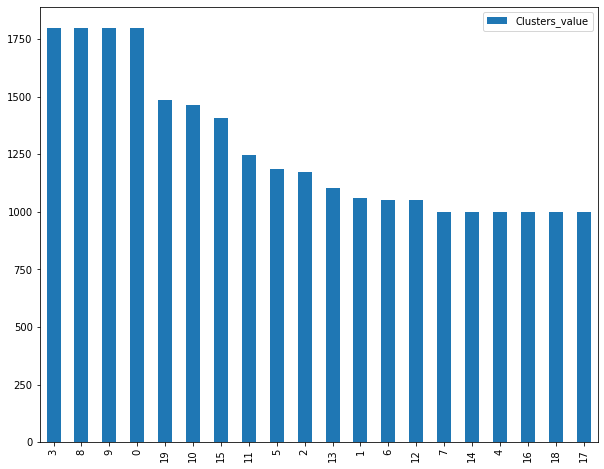

In [9]:
d = {'Clusters_value': df['cluster_label'].value_counts() }
pd.DataFrame(data=d).plot(kind='bar', figsize=(10,8))


In [10]:
df['cluster_label'].value_counts().sort_index()

0     1800
1     1061
2     1173
3     1800
4     1000
5     1188
6     1053
7     1000
8     1800
9     1800
10    1463
11    1249
12    1051
13    1103
14    1000
15    1409
16    1000
17    1000
18    1000
19    1486
Name: cluster_label, dtype: int64

In [11]:
df['cluster_label'].value_counts().sort_values

<bound method Series.sort_values of 3     1800
8     1800
9     1800
0     1800
19    1486
10    1463
15    1409
11    1249
5     1188
2     1173
13    1103
1     1061
6     1053
12    1051
7     1000
14    1000
4     1000
16    1000
18    1000
17    1000
Name: cluster_label, dtype: int64>

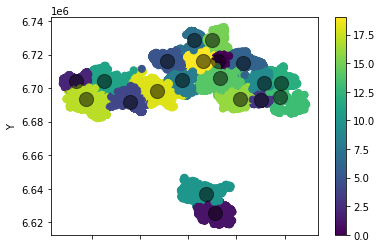

In [12]:
df.plot.scatter(x = 'X', y = 'Y', c=labels, s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

### Merging original file with clustering

In [13]:
clustered_data = df_full.merge(df, left_on='UC', right_on='UC')
clustered_data = clustered_data.drop(['X_x','Y_x'], axis=1)
clustered_data.rename(columns={'X_y':'X', 'Y_y':'Y', 'cluster_label':'CLUSTER'}, inplace = True)
clustered_data.head(20)

,UC,LOCAL,POSTE,SE,AL,LIGADO,CLASSE,X,Y,CLUSTER
0,4,MORRO DO PEDRO ROSA,75934.0,CTJ2,1.0,S,RURAL,427474.595,6714270.209,19
1,11,MORRO DO PEDRO ROSA,24353.0,CTJ2,1.0,S,RESIDENCIAL,426273.037,6713425.845,19
2,13,TABAI,52287.0,CTJ2,1.0,S,COMERCIAL,431613.045,6715311.228,0
3,14,COSTA DO CADEIA,64532.0,CTJ2,1.0,S,RURAL,432818.329,6714907.775,0
4,15,TREVO TABAI,43147.0,CTJ2,1.0,S,RURAL,430488.909,6716056.241,0
5,19,COSTA DO CADEIA,26700.0,CTJ2,1.0,S,RURAL,435026.002,6714015.786,0
6,29,COXILHA VELHA,29378.0,CTJ2,1.0,S,COMERCIAL,433837.075,6713875.914,0
7,32,COSTA DO CADEIA,32981.0,CTJ2,1.0,S,RESIDENCIAL,437636.436,6713461.905,6
8,33,BARRO VERMELHO,30962.0,CTJ2,1.0,S,RURAL,436773.197,6711874.617,14
9,34,PASSO DO GIL,35475.0,CTJ2,1.0,S,RURAL,440428.196,6713575.763,6


### Exporting to excel

In [14]:
clustered_data.to_csv ('clustered_data.csv', index=None, header = True) 
print(f'Arquivo CSV criado com sucesso !') 

Arquivo CSV criado com sucesso !
